In [10]:
import string
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter, ScalarFormatter, NullFormatter

In [11]:
import warnings

warnings.filterwarnings("ignore")

# Non-Conditional

In [12]:
sns.set_theme(color_codes=True, style='ticks', context='talk', font_scale=1.5)

NROWS, NCOLS = 3, 3
DIM_SIZES = [2**i for i in range(2, 13)]
DATA_PATH = "results"
FIG_PATH = "figs"

SIMULATIONS = [
    "linear",
    "nonlinear",
    "independent",
]

S98_KWARGS = {
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    # "KNN_PCA" : {"color" : "#377eb8", "label" : "KNN PCA", "linestyle" : "--"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    # "RF" : {"color" : "#377eb8", "label" : "RF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.14,
        "nonlinear" : 0.26,
        "independent": 0.02
    }
}

MI_KWARGS = {
    # "KSG_PCA" : {"color" : "#4daf4a", "label" : "KSG PCA", "linestyle" : "--"},
    "KSG" : {"color" : "#4daf4a", "lw" : 3, "label" : "KSG"},
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.11,
        "nonlinear" : 0.09,
        "independent": 0.00
    }
}

POWER_KWARGS = {
    "Dcorr_PCA" : {"color" : "#a65628", "lw" : 3, "label" : "Dcorr PCA"},
    "Dcorr" : {"color" : "#ff7f00", "lw" : 3, "label" : "Dcorr"},
    "hypoRF" : {"color" : "#984ea3", "lw" : 3, "label" : "hypoRF"},
    # "might-Acc" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Acc", "linestyle" : "-."},
    # "might-AUC" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT AUC", "linestyle" : "--"},
    # "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT MI", "linestyle" : ":"},
    # "might-S98" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT S@98"},
    "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Alpha" : {
        "linear" : 0.05,
        "nonlinear" : 0.05,
        "independent": 0.05
    }
}

HD_KWARGS = {
    "drf" : {"color" : "#f781bf", "lw" : 3, "label" : "DRF"},
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.24,
        "nonlinear" : 0.25,
        "independent": 0.00
    }
}

STAT_KWARGS = {
    "S98" : {"kwargs" : S98_KWARGS, "title" : "S@98"},
    "MI" : {"kwargs" : MI_KWARGS, "title" : "Mutual Information"},
    "hd" : {"kwargs" : HD_KWARGS, "title" : "Distribution Distance"},
}

## Data Refactor

In [4]:
# Refactor Data
SIMS = {
    "linear" : "trunk",
    "nonlinear" : "trunk_mix",
    "independent" : "trunk_overlap"
}
ALPHA = 0.05

MAX_REPS = {
    "drf" : 10,
    "KSG" : 10,
    "KSG_PCA" : 10,
    "KNN_PCA" : 100,
    "Dcorr" : 1000,
    "Dcorr_PCA" : 1000,
    "hypoRF" : 1000,
}


def refactor_data_s98(data, alg="SVMrbf", type="n"):
    for sim, file_sim in SIMS.items():
        if alg == "KNN_PCA":
            vs = "samp" if type == "n" else "dim" if type == "d" else ""
            dfs = [
                pd.read_csv(f"{data}/{SIMS[sim]}_s98_knnpca_{vs}_rep{rep}.csv", sep=",", header=None)
                for rep in range(MAX_REPS[alg])
            ]
            refactored_data = pd.concat(dfs, axis=1)
            np.savetxt(f"{DATA_PATH}/{sim}-{alg}-S98-vs-{type}.csv", refactored_data, delimiter=",")
        else:
            df = pd.read_csv(data)
            grouped = df.groupby(df.simulation)
            sim_df = grouped.get_group(SIMS[sim])
            grouped = df.groupby(sim_df.model)
            alg_df = grouped.get_group(alg)
            alg_df["n_sample"] = alg_df["n_sample"].astype(int)
            alg_df["n_dim"] = alg_df["n_dim"].astype(int)
            if type == "n":
                vs_sampsize = alg_df[alg_df["n_dim"] == 4096]
                N = vs_sampsize.n_sample.value_counts(sort=False).min()
                N = N - N % len(SAMPLE_SIZES)
                refactored_data = vs_sampsize.sample(frac=1).groupby('n_sample', sort=False).head(N)["s@98"].to_numpy().reshape(len(SAMPLE_SIZES), -1)
            elif type == "d":
                vs_dim = alg_df[alg_df["n_sample"] == 4096]
                N = vs_dim.n_dim.value_counts(sort=False).min()
                N = N - N % len(DIM_SIZES)
                refactored_data = vs_dim.sample(frac=1).groupby('n_dim', sort=False).head(N)["s@98"].to_numpy().reshape(len(DIM_SIZES), -1)
        np.savetxt(f"{DATA_PATH}/{sim}-{alg}-S98-vs-{type}.csv", refactored_data, delimiter=",")


def refactor_data_mi(data, alg="KSG", sim="linear", type="n"):
    file_alg = "ksgpca_" if alg == "KSG_PCA" else ""
    vs = "samp" if type == "n" else "dim" if type == "d" else ""
    dfs = [
        pd.read_csv(f"{data}/{SIMS[sim]}_mi_{file_alg}{vs}_rep{rep}.csv", sep=",", header=None)
        for rep in range(MAX_REPS[alg])
    ]
    df = pd.concat(dfs, axis=1)
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-MI-vs-{type}.csv", df.to_numpy(), delimiter=",")



def refactor_data_power(alg="Dcorr", sim="linear", type="n"):
    power = []
    if type == "n":
        file_path = f"p-4096_n-256_4096/{sim}_{alg}"
        for samp_size in SAMPLE_SIZES:
            if alg == "hypoRF":
                alt_dist, null_dist = map(
                    np.float64,
                    zip(*[
                        np.genfromtxt(f"{file_path}_{samp_size}_{rep}.txt")
                        for rep in range(MAX_REPS[alg])
                    ]),
                )
                cutoff = np.sort(1 - null_dist)[math.ceil(MAX_REPS[alg] * (1 - ALPHA))]
                empirical_power = (1 + ((1 - alt_dist) >= cutoff).sum()) / (1 + MAX_REPS[alg])
            else:
                pvals = np.array([
                    np.genfromtxt(f"{file_path}_{samp_size}_{rep}.txt")
                    for rep in range(MAX_REPS[alg])
                ])
                empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + MAX_REPS[alg])
            power.append(empirical_power)
    elif type == "d":
        file_path = f"n-256_p-4_4096/{sim}_{alg}"
        for dim in DIM_SIZES:
            if alg == "hypoRF":
                alt_dist, null_dist = map(
                    np.float64,
                    zip(*[
                        np.genfromtxt(f"{file_path}_{dim}_{rep}.txt")
                        for rep in range(MAX_REPS[alg])
                    ]),
                )
                cutoff = np.sort(1 - null_dist)[math.ceil(MAX_REPS[alg] * (1 - ALPHA))]
                empirical_power = (1 + ((1 - alt_dist) >= cutoff).sum()) / (1 + MAX_REPS[alg])
            else:
                pvals = np.array([
                    np.genfromtxt(f"{file_path}_{dim}_{rep}.txt")
                    for rep in range(MAX_REPS[alg])
                ])
                empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + MAX_REPS[alg])
            power.append(empirical_power)
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-power-vs-{type}.csv", power, delimiter=",")


def refactor_data_hd(data=None, alg="might", sim="linear", type="n"):
    if alg == "might":
        hd = np.genfromtxt(f"raw_results/{sim}-{alg}-hd-vs-{type}.csv", delimiter=',')
        if type == "n":
            for i, samp_size in enumerate(SAMPLE_SIZES):
                hd[i, :] = hd[i, :] / np.sqrt(samp_size)
        elif type == "d":
            for i, dim in enumerate(DIM_SIZES):
                hd[i, :] = hd[i, :] / np.sqrt(4096)
    elif alg == "drf":
        if type == "n":
            dfs = [
                pd.read_csv(f"{data}/{SIMS[sim]}_helldistance_samp_rep{rep}.csv", sep=",", header=None)
                for rep in range(MAX_REPS[alg])
            ]
            df = pd.concat(dfs, axis=1)
        elif type == "d":
            dfs = [
                pd.read_csv(f"{data}/{SIMS[sim]}_helldistance_dim_rep{rep}.csv", sep=",", header=None)
                for rep in range(MAX_REPS[alg])
            ]
            df = pd.concat(dfs, axis=1)
        hd = df.to_numpy()
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-hd-vs-{type}.csv", hd, delimiter=",")

In [ ]:
for type in ["n"]:#, "d"]:
    # for alg in ["SVMrbf", "LRliblinear", "KNN", "RF"]:
    for alg in ["KNN", "KNN_PCA"]:
        data = "raw_results/result_knn" if alg == "KNN_PCA" else "raw_results/s98_results_.csv"
        refactor_data_s98(data=data, alg=alg, type=type)

In [6]:
for sim in SIMS.keys():
    for type in ["n"]:#, "d"]:
        for alg in ["KSG", "KSG_PCA"]:
            refactor_data_mi(data="raw_results/result_ksg", type=type, sim=sim)

In [7]:
for sim in ["linear", "nonlinear", "independent"]:
    for type in ["n", "d"]:
        for alg in ["Dcorr", "Dcorr_PCA", "hypoRF"]:
            refactor_data_power(alg=alg, type=type, sim=sim)

In [8]:
for sim in ["linear", "nonlinear", "independent"]:
    for type in ["n", "d"]:
        for alg in ["might", "drf"]:
            refactor_data_hd(data="raw_results/result_drf", alg=alg, type=type, sim=sim)

## Plot Figures

In [26]:
def plot_stats(plot_type="vs-n", fig_name="figure-2"):
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(16, 14))

    lines = []
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            stat = list(STAT_KWARGS.keys())[r]
            stat_kwargs = STAT_KWARGS[stat]["kwargs"]
            col.axhline(y=stat_kwargs["Truth"][sim], linestyle=":", color="#000000", label="Truth")

            for test, plot_kwargs in stat_kwargs.items():
                if plot_type == "vs-n":
                    xs = [256, 512, 1024, 2048, 4096]
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-{stat}-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif plot_type == "vs-d":
                    xs = DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-{stat}-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue

                medians = np.quantile(ys, 0.5, axis=1)
                lower_quartile = np.quantile(ys, 0.25, axis=1)
                upper_quartile = np.quantile(ys, 0.75, axis=1)
                medians = np.array([y if y > 0 else 0 for y in medians])
                lower_quartile = np.array([y if y > 0 else 0 for y in lower_quartile])
                upper_quartile = np.array([y if y > 0 else 0 for y in upper_quartile])
                line = col.plot(xs, medians, **plot_kwargs)
                col.fill_between(xs, lower_quartile, upper_quartile, alpha=0.2, color=plot_kwargs["color"])
                lines.extend(line)

            col.set(
                title=(
                    "Null" if c == 2 and r == 0
                    else sim.capitalize() if r == 0
                    else ""
                ),
                xlabel=(
                    "Sample Size" if plot_type == "vs-n" and r == 2
                    else "# of Variables" if plot_type == "vs-d" and r == 2
                    else ""
                ),
                ylabel=(
                    f"{STAT_KWARGS[stat]['title']}\nfor 4096 Variables" if plot_type == "vs-n" and c == 0
                    else f"{STAT_KWARGS[stat]['title']}\nfor 4096 Samples" if plot_type == "vs-d" and c == 0
                    else ""
                ),
                yticks=(
                    [0, stat_kwargs["Truth"][sim], 0.1] if c == 2
                    else [0, stat_kwargs["Truth"][sim]]
                ),
                ylim=(
                    # else [-0.001, 0.1] if c == 2 and stat == "S98"
                    [-0.001, 0.1] if c == 2 #and stat in ["MI", "hd"]
                    else [-0.001, stat_kwargs["Truth"][sim] + 0.4 * stat_kwargs["Truth"][sim]]
                ),
                xticks=(
                    [256, 2048, 4096] if plot_type == "vs-n"
                    else [4, 2048, 4096] if plot_type == "vs-d"
                    else ""
                )
            )
            col.get_yaxis().set_major_formatter(StrMethodFormatter("{x:.2f}"))
            col.set_title(string.ascii_uppercase[r * NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)

    legend_locs = [0.99, 0.66, 0.33]
    for i in range(NROWS):
        leg = ax[i, 0].legend(
            bbox_to_anchor=(1.05, legend_locs[i]),
            bbox_transform=plt.gcf().transFigure,
            ncol=1,
            loc="upper center",
            reverse=True
        )
        leg.get_frame().set_linewidth(0.0)
        for legobj in leg.legend_handles:
            legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')


def plot_power(fig_name="figure-4"):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            col.axhline(y=POWER_KWARGS["Alpha"][sim], linestyle=":", color="#000000", label="Alpha")

            for test, plot_kwargs in POWER_KWARGS.items():
                if r == 0:
                    xs = [64, 128, 256, 512, 1024]
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-power-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif r == 1:
                    xs = DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/{sim}-{test}-power-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                ys = np.array([y if y > 0 else 0 for y in ys])
                if r == 0:
                    col.plot(xs[:5], ys[:5], **plot_kwargs)
                else:
                    col.plot(xs, ys, **plot_kwargs)

            col.set(
                xscale="log" if r == 0 else "linear",
                title=(
                    "Null" if c == 2 and r == 0
                    else sim.capitalize() if r == 0
                    else ""
                ),
                xlabel=(
                    "Sample Size (Log Scale)" if r == 0
                    else "# of Variables" if r == 1
                    else ""
                ),
                ylabel=(
                    f"Power\nfor 4096 Variables" if r == 0 and c == 0
                    else f"Power\nfor 256 Samples" if r == 1 and c == 0
                    else ""
                ),
                yticks=[0, 1.0],
                ylim=[-0.01, 1.01],
                xticks=(
                    # [256, 2048, 4096] if r == 0
#                     [256, 1024, 2048] if r == 0
                    [64, 256, 1024] if r == 0
                    else [4, 2048, 4096] if r == 1
                    else ""
                )
            )
            col.xaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_minor_formatter(NullFormatter())
            col.set_title(string.ascii_uppercase[r * 3 + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)

    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.01),
        bbox_transform=plt.gcf().transFigure,
        # ncol=len(POWER_KWARGS) // 2,
        ncol=len(POWER_KWARGS),
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')

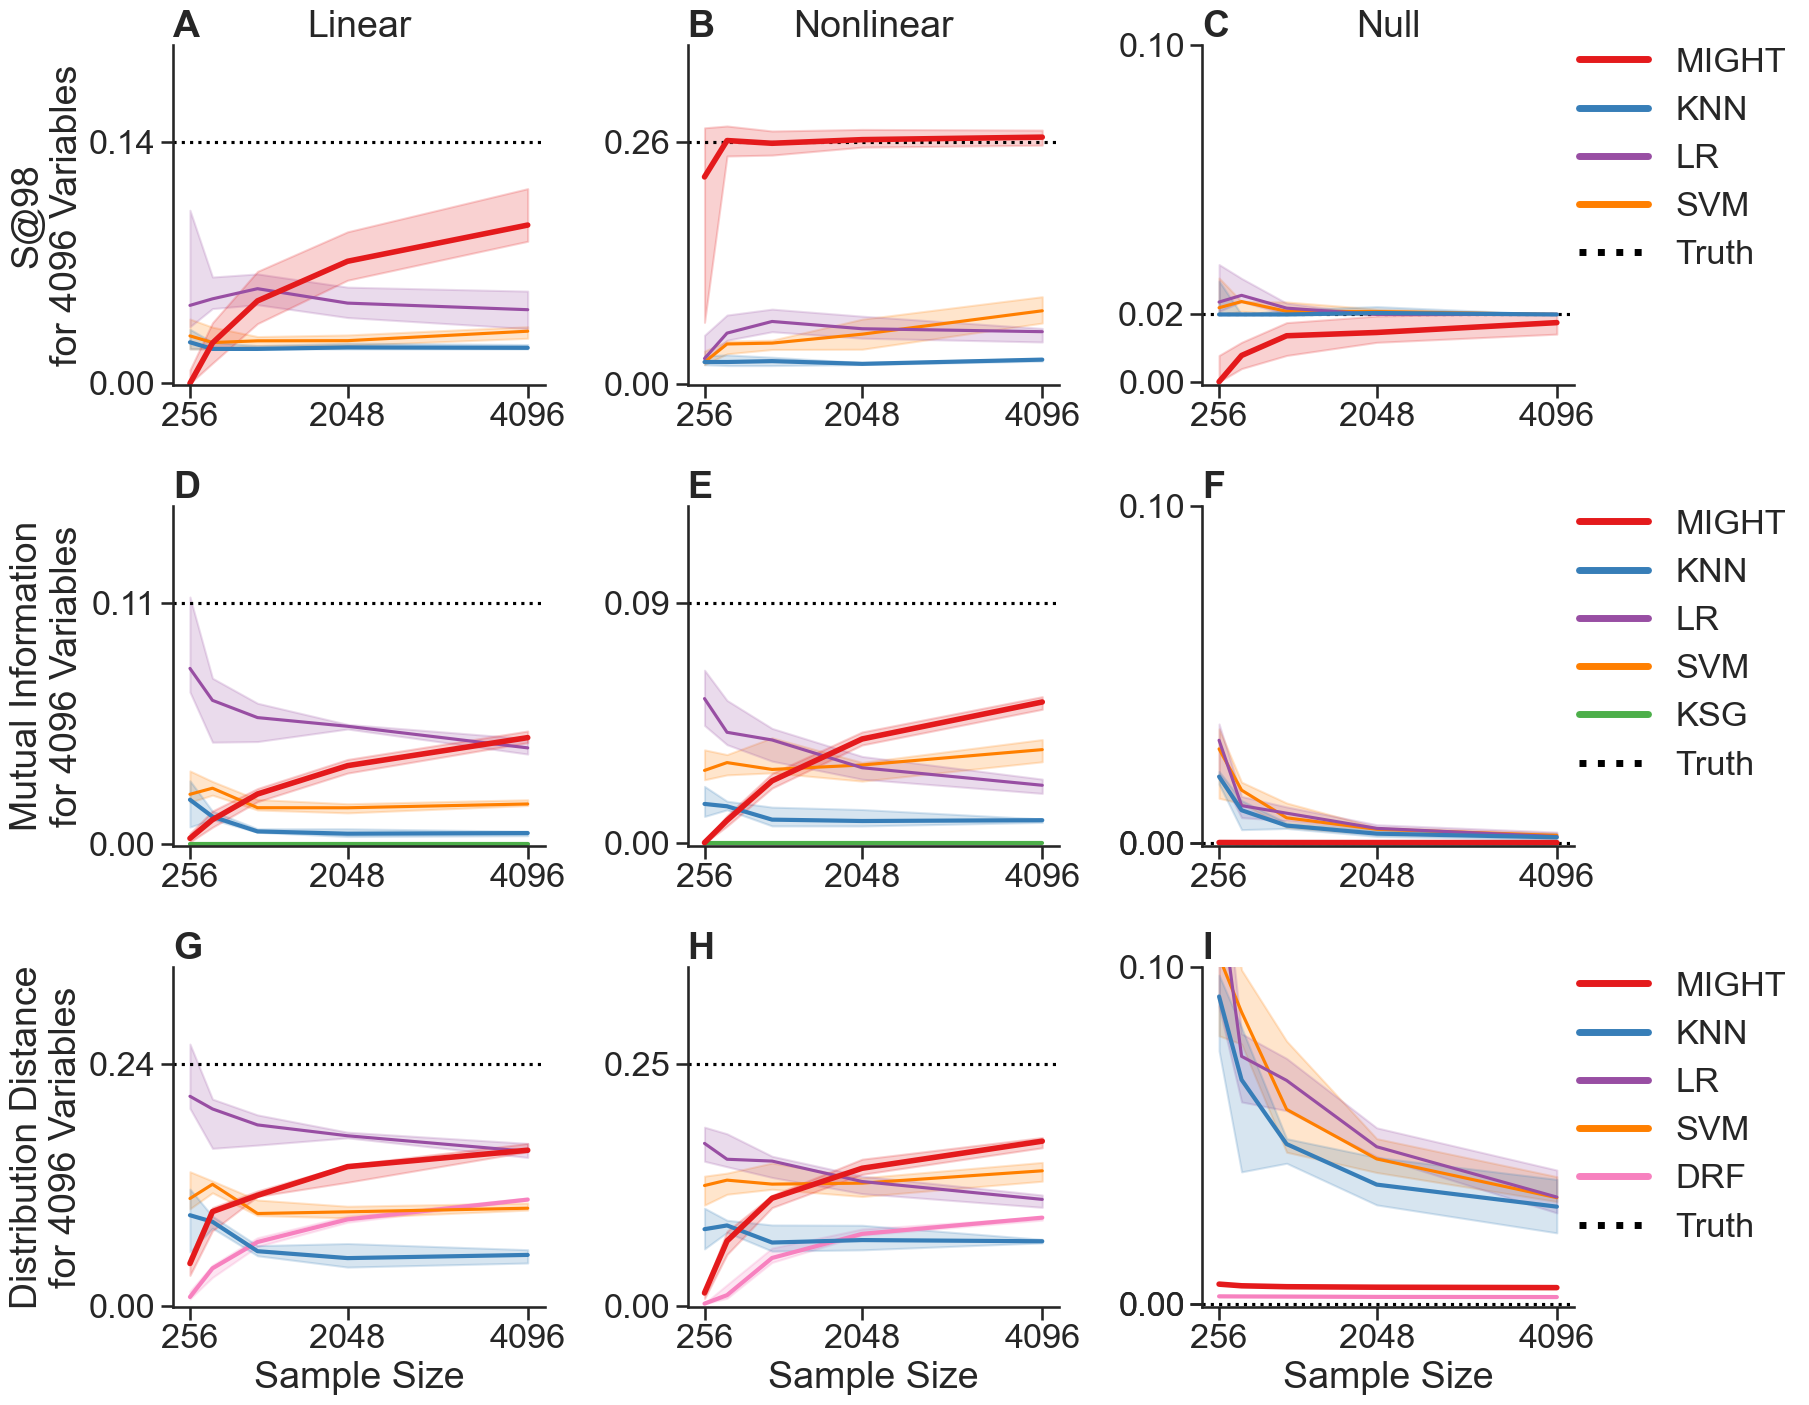

In [27]:
plot_stats(plot_type="vs-n", fig_name="figure-2")

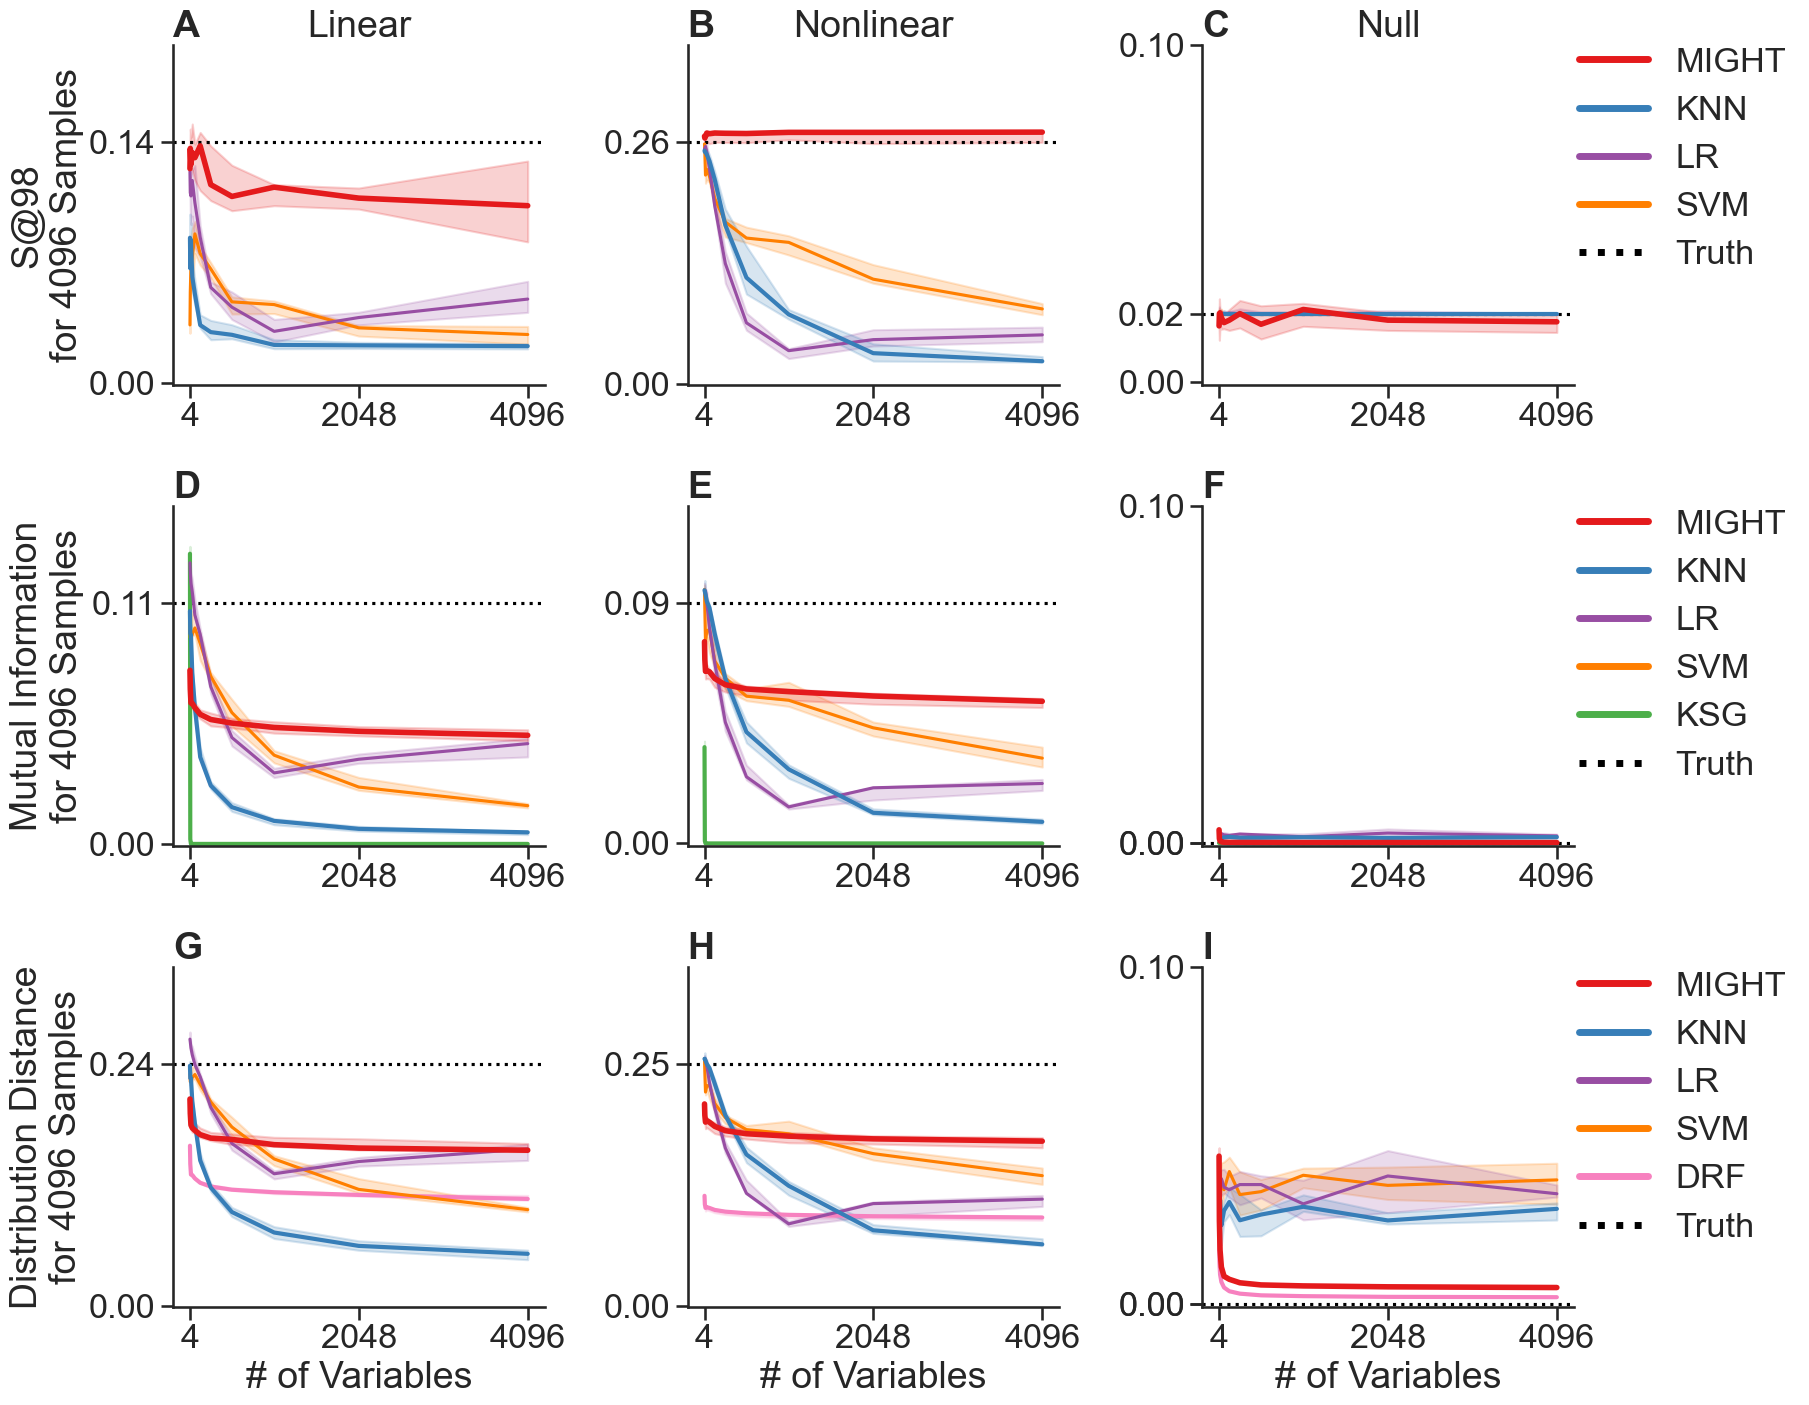

In [28]:
plot_stats(plot_type="vs-d", fig_name="figure-s2")

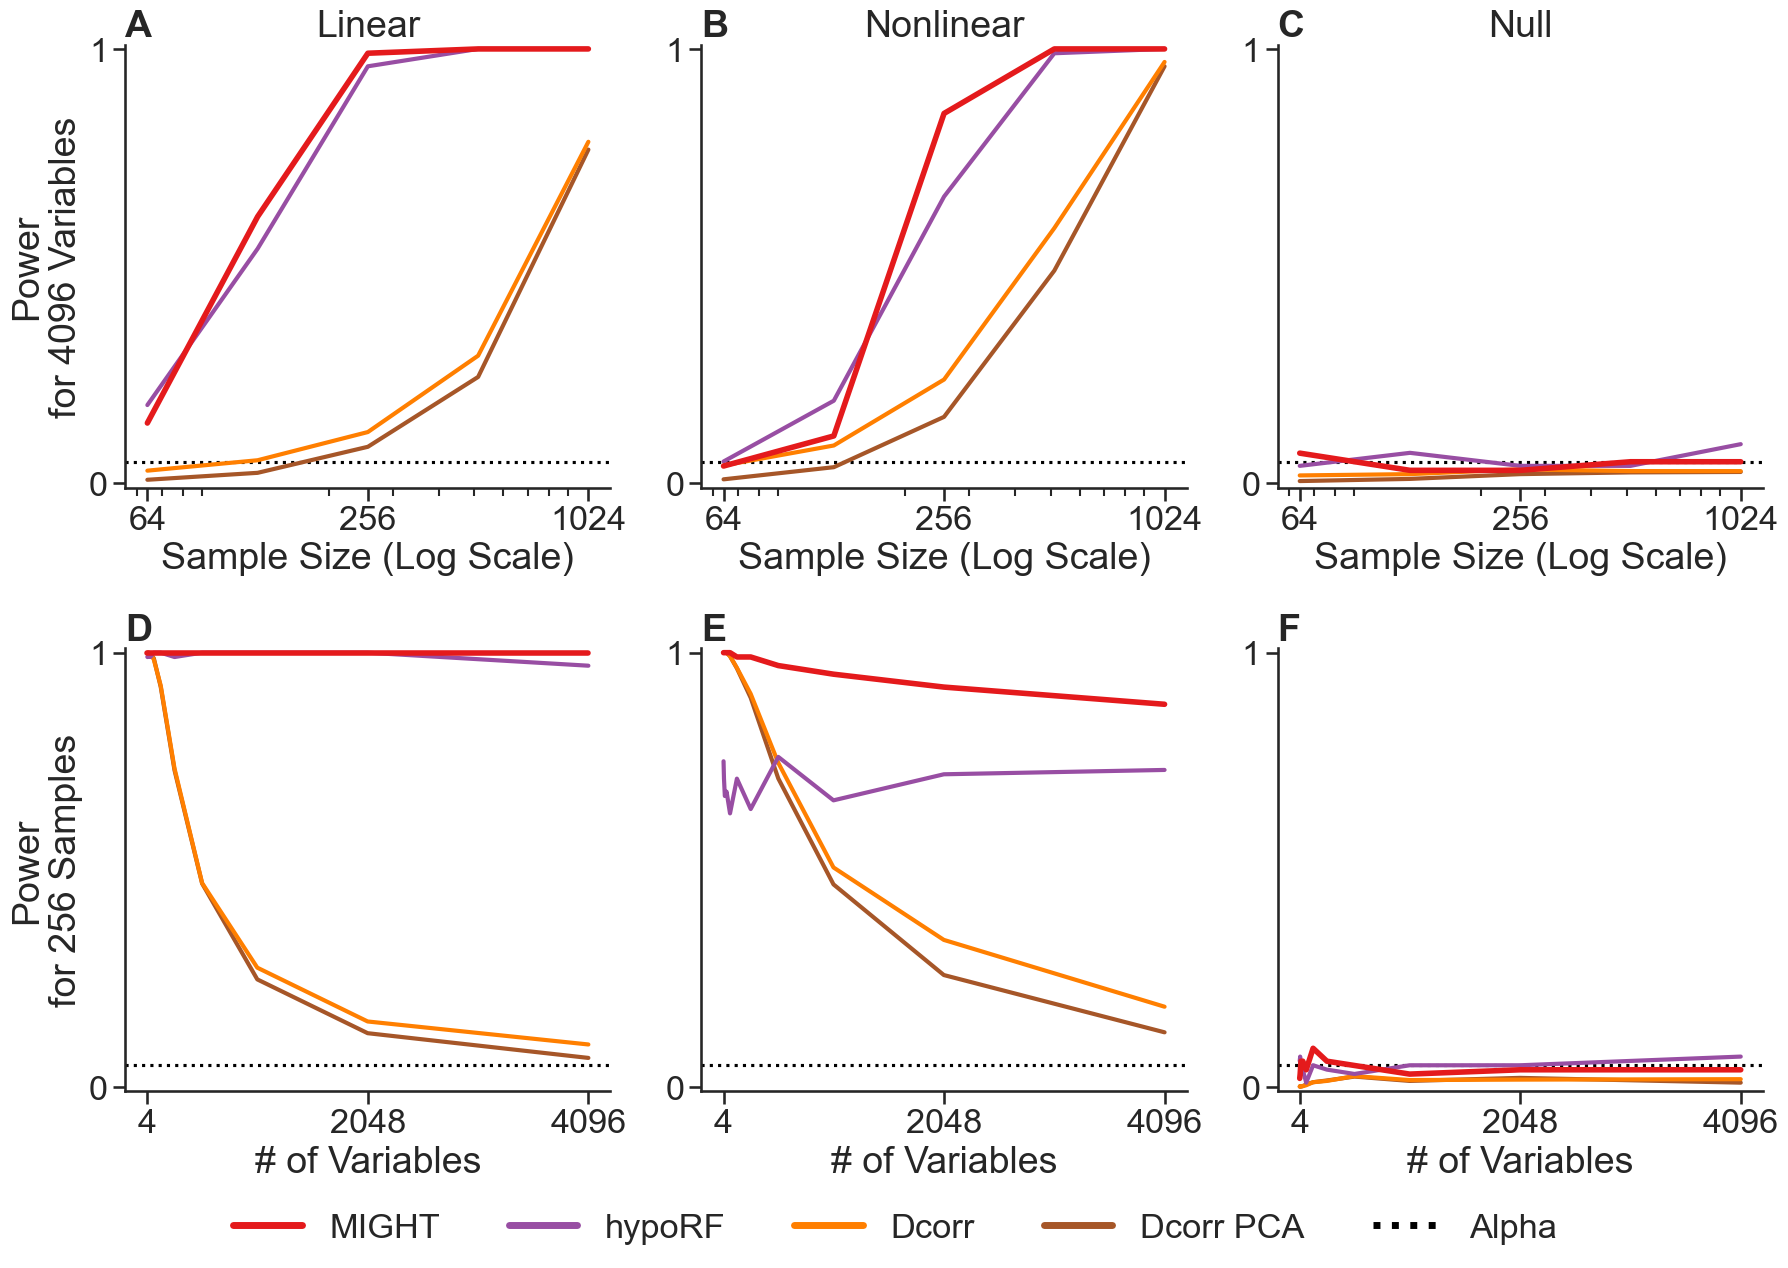

In [29]:
plot_power(fig_name="figure-4")

# Conditional

In [78]:
CO_NROWS, CO_NCOLS = 2, 3
CO_DIM_SIZES = [2, 10, 26, 58, 122, 250, 506, 1018, 2042, 4090]

CO_SIMS = {
    "linear" : "mean_shiftv2",
    "nonlinear" : "multi_modalv2",
    "independent" : "multi_equal"
}

CO_ALGS_STATS = {
    "sas98" : ["comight", "knn", "knn_viewtwo", "knn_viewone", "might_viewone", "might_viewtwo"],
    "cmi" : ["comight", "ksg"],
}

CO_S98_KWARGS = {
    "knn_viewtwo" : {"color" : "#377eb8", "label" : "KNN View 2", "linestyle" : "-."},
    "knn_viewone" : {"color" : "#377eb8", "label" : "KNN View 1", "linestyle" : "--"},
    "knn" : {"color" : "#377eb8", "label" : "KNN"},
    "might_viewtwo" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT View 2", "linestyle" : "-."},
    "might_viewone" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT View 1", "linestyle" : "--"},
    "comight" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT"},
    "Truth" : {
        "linear" : 0.26,
        "nonlinear" : 0.28,
        "independent": 0.02
    }
}

CMI_KWARGS = {
    "ksg" : {"color" : "#4daf4a", "label" : "KSG"},
    "comight" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT"},
    "Truth" : {
        "linear" : 0.11,
        "nonlinear" : 0.15,
        "independent": 0
    }
}

CO_POWER_KWARGS = {
    # "Dcorr_PCA" : {"color" : "#ff7f00", "lw" : 2, "label" : "Dcorr PCA", "linestyle" : "--"},
    # "Dcorr" : {"color" : "#ff7f00", "lw" : 2, "label" : "Dcorr"},
    # "hypoRF" : {"color" : "#984ea3", "lw" : 2, "label" : "hypoRF"},
    # "might-Acc" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Acc", "linestyle" : "-."},
    # "might-AUC" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT AUC", "linestyle" : "--"},
    # "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT MI", "linestyle" : ":"},
    # "might-S98" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT S@98"},
    "cond_dcorr" : {"color" : "#ff7f00", "lw" : 2, "label" : "Conditional Dcorr"},
    "comight_mi" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT MI", "linestyle" : ":"},
    "comight_sas98" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT S@98"},
    "Alpha" : {
        "linear" : 0.05,
        "nonlinear" : 0.05,
        "independent": 0.05
    }
}

COMIGHT_STAT_KWARGS = {
    "cmi" : {"kwargs" : CMI_KWARGS, "title" : "Conditional Mutual Information"},
    "sas98" : {"kwargs" : CO_S98_KWARGS, "title" : "S@98"},
}

## Data Refactor

In [79]:
TYPES = {
    "n" : {"vs" : "nsamples", "groupby" : "n_samples", "size_list" : SAMPLE_SIZES},
    "d" : {"vs" : "ndims", "groupby" : "n_dims_1", "size_list" : CO_DIM_SIZES},
}


def _get_refactored_data(df, sim="linear", stat="cmi", type_kwargs=None):
    df = df[df["sim_type"] == CO_SIMS[sim]]
    df = df[df["metric"] == stat]
    N = df[type_kwargs["groupby"]].value_counts(sort=False).min()
    refactored_data = df.sample(frac=1).groupby(type_kwargs["groupby"], sort=False).head(N)["metric_value"].to_numpy().reshape(len(type_kwargs["size_list"]), -1)
    return refactored_data, N


def refactor_data_stats(data, alg="comight", sim="linear", type="n", stat="cmi"):
    type_kwargs = TYPES[type]
    ndims = 1018 if stat == "cmi" else 4090
    df = pd.read_csv(data + f"/results_vs_{type_kwargs['vs']}_{CO_SIMS[sim]}_{alg}_{stat}_{ndims}_100.csv")
    refactored_data, _ = _get_refactored_data(df, sim=sim, stat=stat, type_kwargs=type_kwargs)
    np.savetxt(f"{DATA_PATH}/conditional/{sim}-conditional-{alg}-{stat}-vs-{type}.csv", refactored_data, delimiter=",")


def refactor_data_power(data, alg="comight", sim="linear", type="n", stat="cmi"):
    type_kwargs = TYPES[type]
    df = pd.read_csv(data + f"/results_vs_{type_kwargs['vs']}_{CO_SIMS[sim]}_{alg}_{stat}_4090_100.csv")
    df_perm = pd.read_csv(data + f"/results_vs_{type_kwargs['vs']}_{CO_SIMS[sim]}_{alg}-perm_{stat}_4090_100.csv")
    refactored_data, N = _get_refactored_data(df, sim=sim, stat=stat, type_kwargs=type_kwargs)
    refactored_data_perm, N_perm = _get_refactored_data(df_perm, sim=sim, stat=stat, type_kwargs=type_kwargs)
    power = []
    power_reps = min(N, N_perm)
    for i in range(len(type_kwargs["size_list"])):
        alt_dist, null_dist = refactored_data[i, :], refactored_data_perm[i, :]
        cutoff = np.sort(null_dist)[math.ceil(power_reps * (1 - ALPHA))]
        empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + power_reps)
        power.append(empirical_power)
    np.savetxt(f"{DATA_PATH}/conditional/{sim}-conditional-power-{alg}-{stat}-vs-{type}.csv", power, delimiter=",")

In [80]:
for stat, algs in CO_ALGS_STATS.items():
    for sim in CO_SIMS.keys():
        for type in ["n", "d"]:
            for alg in algs:
                try:
                    refactor_data_stats(data="raw_results/comight", alg=alg, sim=sim, type=type, stat=stat)
                except FileNotFoundError:
                    print(f"{DATA_PATH}/conditional/{sim}-conditional-{alg}-{stat}-vs-{type}.csv skipped")
                    continue

results/conditional/linear-conditional-comight-sas98-vs-d.csv skipped
results/conditional/nonlinear-conditional-might_viewone-sas98-vs-n.csv skipped
results/conditional/nonlinear-conditional-might_viewtwo-sas98-vs-n.csv skipped
results/conditional/nonlinear-conditional-might_viewone-sas98-vs-d.csv skipped
results/conditional/nonlinear-conditional-might_viewtwo-sas98-vs-d.csv skipped
results/conditional/independent-conditional-might_viewone-sas98-vs-n.csv skipped
results/conditional/independent-conditional-might_viewone-sas98-vs-d.csv skipped
results/conditional/linear-conditional-comight-cmi-vs-d.csv skipped
results/conditional/nonlinear-conditional-comight-cmi-vs-n.csv skipped
results/conditional/nonlinear-conditional-comight-cmi-vs-d.csv skipped


In [81]:
# df = pd.read_csv("raw_results/comight/results_vs_nsamples_knn_sas98_4090_100.csv")
# unique_models = pd.unique(df["model"])
# grouped = df.groupby(df.model)
# for model in unique_models:
#     df_model = grouped.get_group(model)
#     df_model.to_csv(f"raw_results/comight/results_vs_nsamples_{model}_sas98_4090_100.csv")

In [82]:
for stat in CO_POWER_KWARGS.keys():
    if stat != "Alpha":
        for sim in CO_SIMS.keys():
            for type in ["n", "d"]:
                alg, stat_split = stat.split("_")
                try:
                    refactor_data_power(data="raw_results/comight", sim=sim, type=type, stat=stat_split, alg=alg)
                except FileNotFoundError:
                    print(f"{DATA_PATH}/conditional/{sim}-conditional-power-{alg}-{stat}-vs-{type}.csv skipped")
                    continue

results/conditional/linear-conditional-power-cond-cond_dcorr-vs-n.csv skipped
results/conditional/linear-conditional-power-cond-cond_dcorr-vs-d.csv skipped
results/conditional/nonlinear-conditional-power-cond-cond_dcorr-vs-n.csv skipped
results/conditional/nonlinear-conditional-power-cond-cond_dcorr-vs-d.csv skipped
results/conditional/independent-conditional-power-cond-cond_dcorr-vs-n.csv skipped
results/conditional/independent-conditional-power-cond-cond_dcorr-vs-d.csv skipped
results/conditional/linear-conditional-power-comight-comight_mi-vs-n.csv skipped
results/conditional/linear-conditional-power-comight-comight_mi-vs-d.csv skipped
results/conditional/nonlinear-conditional-power-comight-comight_mi-vs-n.csv skipped
results/conditional/nonlinear-conditional-power-comight-comight_mi-vs-d.csv skipped
results/conditional/independent-conditional-power-comight-comight_mi-vs-n.csv skipped
results/conditional/independent-conditional-power-comight-comight_mi-vs-d.csv skipped
results/condit

## Plot Figures

In [83]:
def plot_co_stats(plot_type="vs-n", fig_name="figure-5"):
    fig, ax = plt.subplots(nrows=CO_NROWS, ncols=CO_NCOLS, figsize=(18, 12))

    lines = []
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            stat = list(COMIGHT_STAT_KWARGS.keys())[r]
            stat_kwargs = COMIGHT_STAT_KWARGS[stat]["kwargs"]
            col.axhline(y=stat_kwargs["Truth"][sim], linestyle=":", color="#000000", label="Truth")

            for test, plot_kwargs in stat_kwargs.items():
                if plot_type == "vs-n":
                    xs = SAMPLE_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-{test}-{stat}-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif plot_type == "vs-d":
                    xs = CO_DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-{test}-{stat}-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                medians = np.quantile(ys, 0.5, axis=1)
                lower_quartile = np.quantile(ys, 0.25, axis=1)
                upper_quartile = np.quantile(ys, 0.75, axis=1)
                medians = np.array([y if y > 0 else 0 for y in medians])
                lower_quartile = np.array([y if y > 0 else 0 for y in lower_quartile])
                upper_quartile = np.array([y if y > 0 else 0 for y in upper_quartile])
                line = col.plot(xs, medians, **plot_kwargs)
                col.fill_between(xs, lower_quartile, upper_quartile, alpha=0.2, color=plot_kwargs["color"])
                lines.extend(line)

            col.set(
                title=(
                    "Null" if c == 2
                    else sim.capitalize() if r == 0
                    else ""
                ),
                xlabel=(
                    "Sample Size" if plot_type == "vs-n" and r == 1
                    else "# of Variables" if plot_type == "vs-d" and r == 1
                    else ""
                ),
                ylabel=(
                    f"{COMIGHT_STAT_KWARGS[stat]['title']}\nfor 1024 Variables" if plot_type == "vs-n" and c == 0 and r == 0
                    else f"{COMIGHT_STAT_KWARGS[stat]['title']}\nfor 4096 Variables" if plot_type == "vs-n" and c == 0
                    else f"{COMIGHT_STAT_KWARGS[stat]['title']}\nfor 4096 Samples" if plot_type == "vs-d" and c == 0
                    else ""
                ),
                yticks=(
                    [0, stat_kwargs["Truth"][sim], 0.1] if c == 2
                    else [0, stat_kwargs["Truth"][sim]]
                ),
                ylim=(
                    # else [-0.001, 0.1] if c == 2 and stat == "S98"
                    [-0.001, 0.1] if c == 2 #and stat in ["MI", "hd"]
                    else [-0.001, stat_kwargs["Truth"][sim] + 0.4 * stat_kwargs["Truth"][sim]]
                ),
                xticks=(
                    [256, 2048, 4096] if plot_type == "vs-n"
                    else [4, 2048, 4096] if plot_type == "vs-d"
                    else ""
                )
            )
            col.get_yaxis().set_major_formatter(StrMethodFormatter("{x:.2f}"))
            col.set_title(string.ascii_uppercase[r * CO_NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)

    legend_locs = [(1.08, 0.99), (1.1, 0.49)]
    for i in range(CO_NROWS):
        leg = ax[i, 0].legend(
            bbox_to_anchor=legend_locs[i],
            bbox_transform=plt.gcf().transFigure,
            ncol=1,
            loc="upper center",
            reverse=True
        )
        leg.get_frame().set_linewidth(0.0)
        for legobj in leg.legend_handles:
            legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')


def plot_co_power(fig_name="figure-s4"):
    fig, ax = plt.subplots(nrows=2, ncols=CO_NCOLS, figsize=(18, 12))

    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            col.axhline(y=CO_POWER_KWARGS["Alpha"][sim], linestyle=":", color="#000000", label="Alpha")

            for test, plot_kwargs in CO_POWER_KWARGS.items():
                if r == 0:
                    xs = SAMPLE_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-power-{test.replace('_', '-')}-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif r == 1:
                    xs = CO_DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-power-{test.replace('_', '-')}-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                ys = np.array([y if y > 0 else 0 for y in ys])
                col.plot(xs, ys, **plot_kwargs)

            col.set(
                # xscale="log" if r == 0 else "linear",
                title=(
                    "Null" if c == 2
                    else sim.capitalize() if r == 0
                    else ""
                ),
                xlabel=(
                    "Sample Size (Log Scale)" if r == 0
                    else "# of Variables in View 1" if r == 1
                    else ""
                ),
                ylabel=(
                    f"Power\nfor 4096 Variables" if r == 0 and c == 0
                    else f"Power\nfor 512 Samples" if r == 1 and c == 0
                    else ""
                ),
                yticks=[0, 1.0],
                ylim=[-0.01, 1.01],
                xticks=(
                    [256, 2048, 4096] if r == 0
                    else [2, 2042, 4090] if r == 1
                    else ""
                )
            )
            col.xaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_minor_formatter(NullFormatter())
            col.set_title(string.ascii_uppercase[r * CO_NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)

    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.01),
        bbox_transform=plt.gcf().transFigure,
        # ncol=len(POWER_KWARGS) // 2,
        ncol=len(POWER_KWARGS),
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')

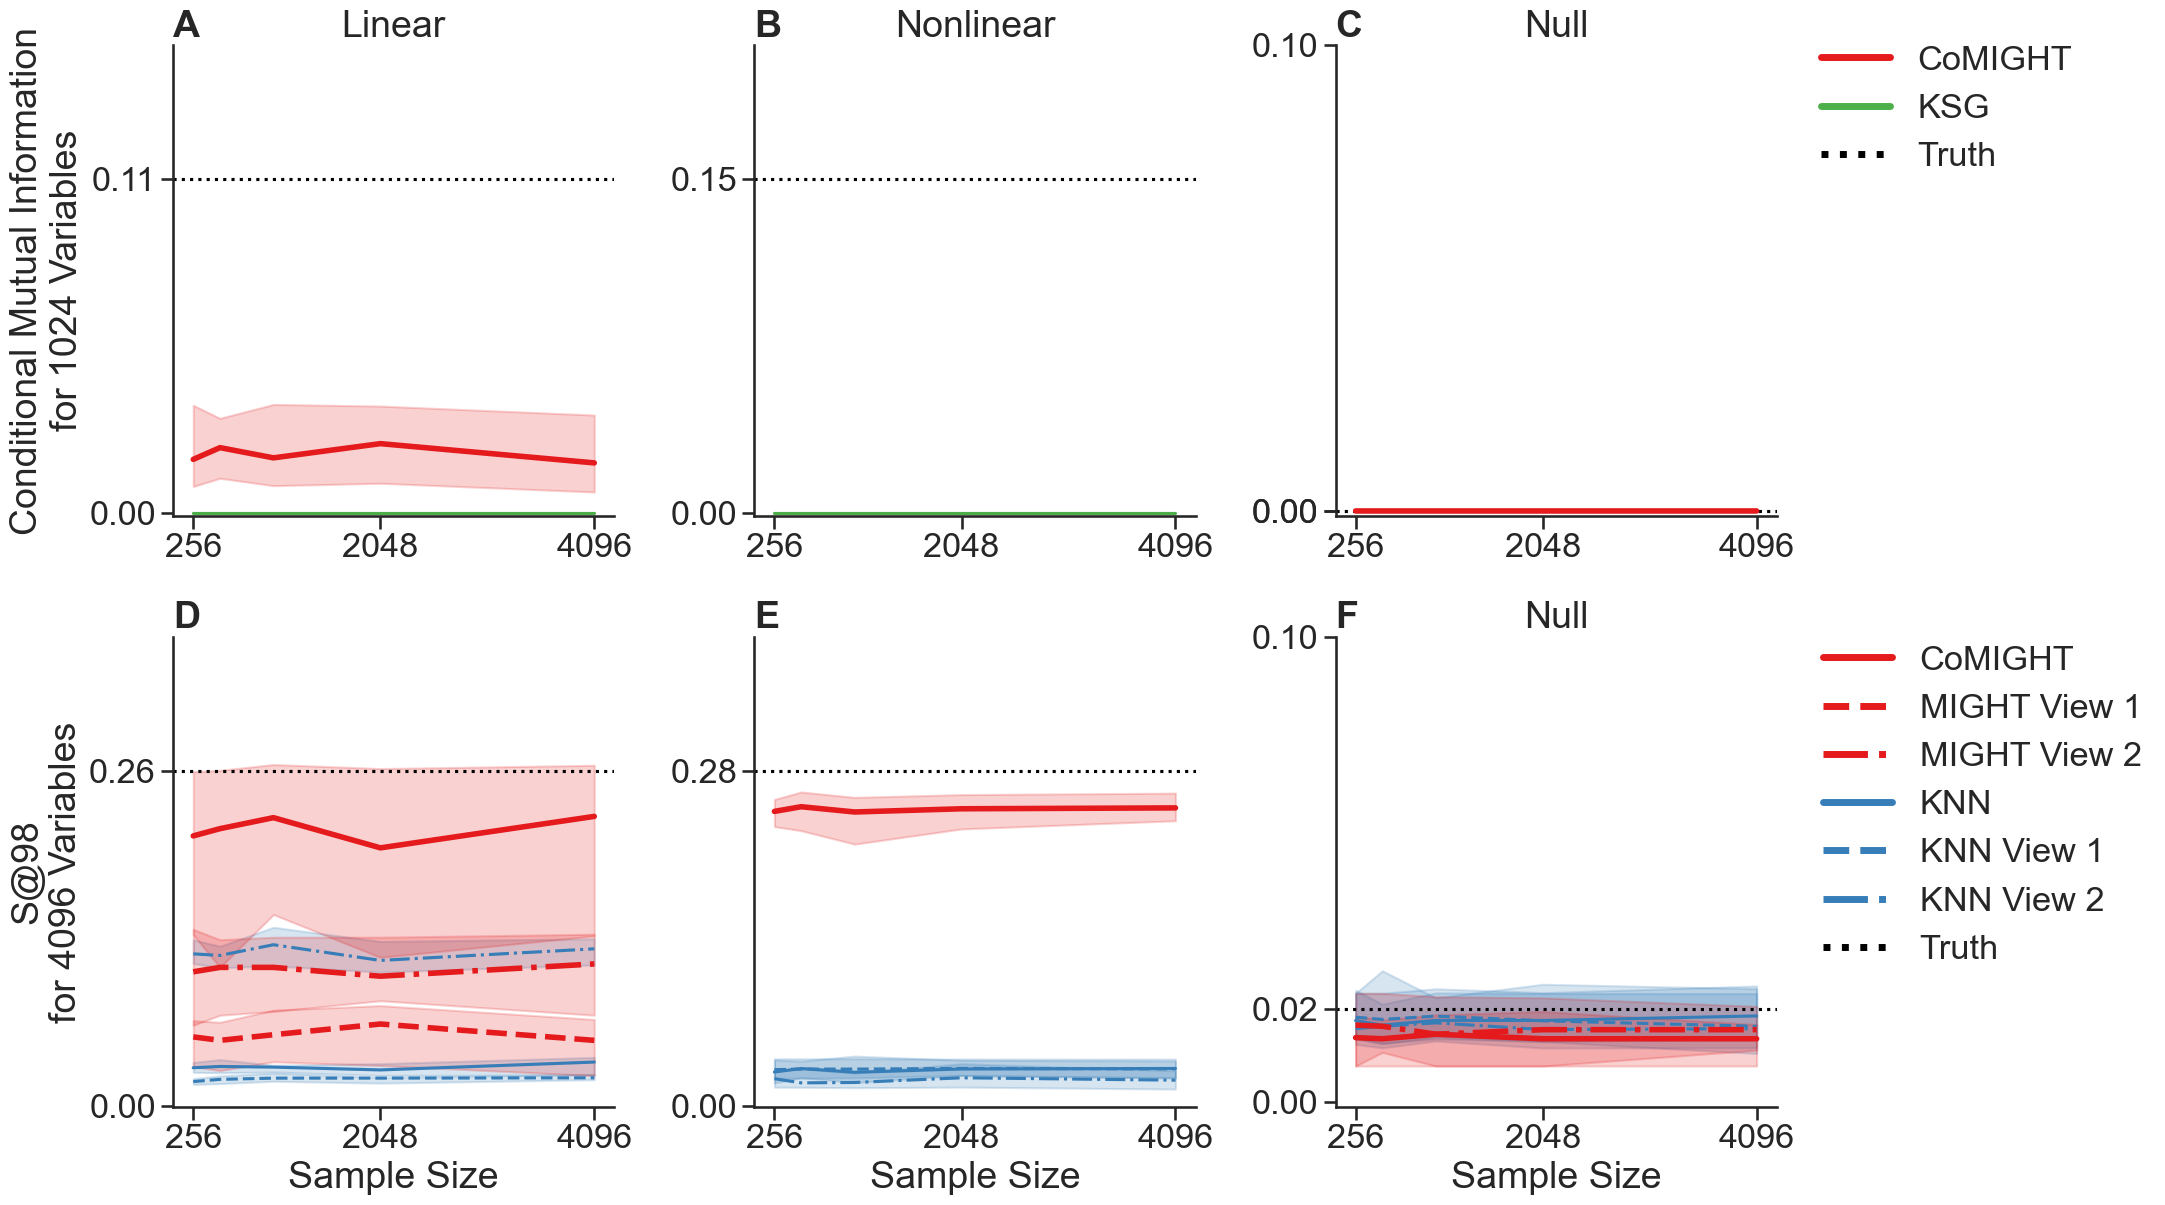

In [84]:
plot_co_stats(plot_type="vs-n", fig_name="figure-5")

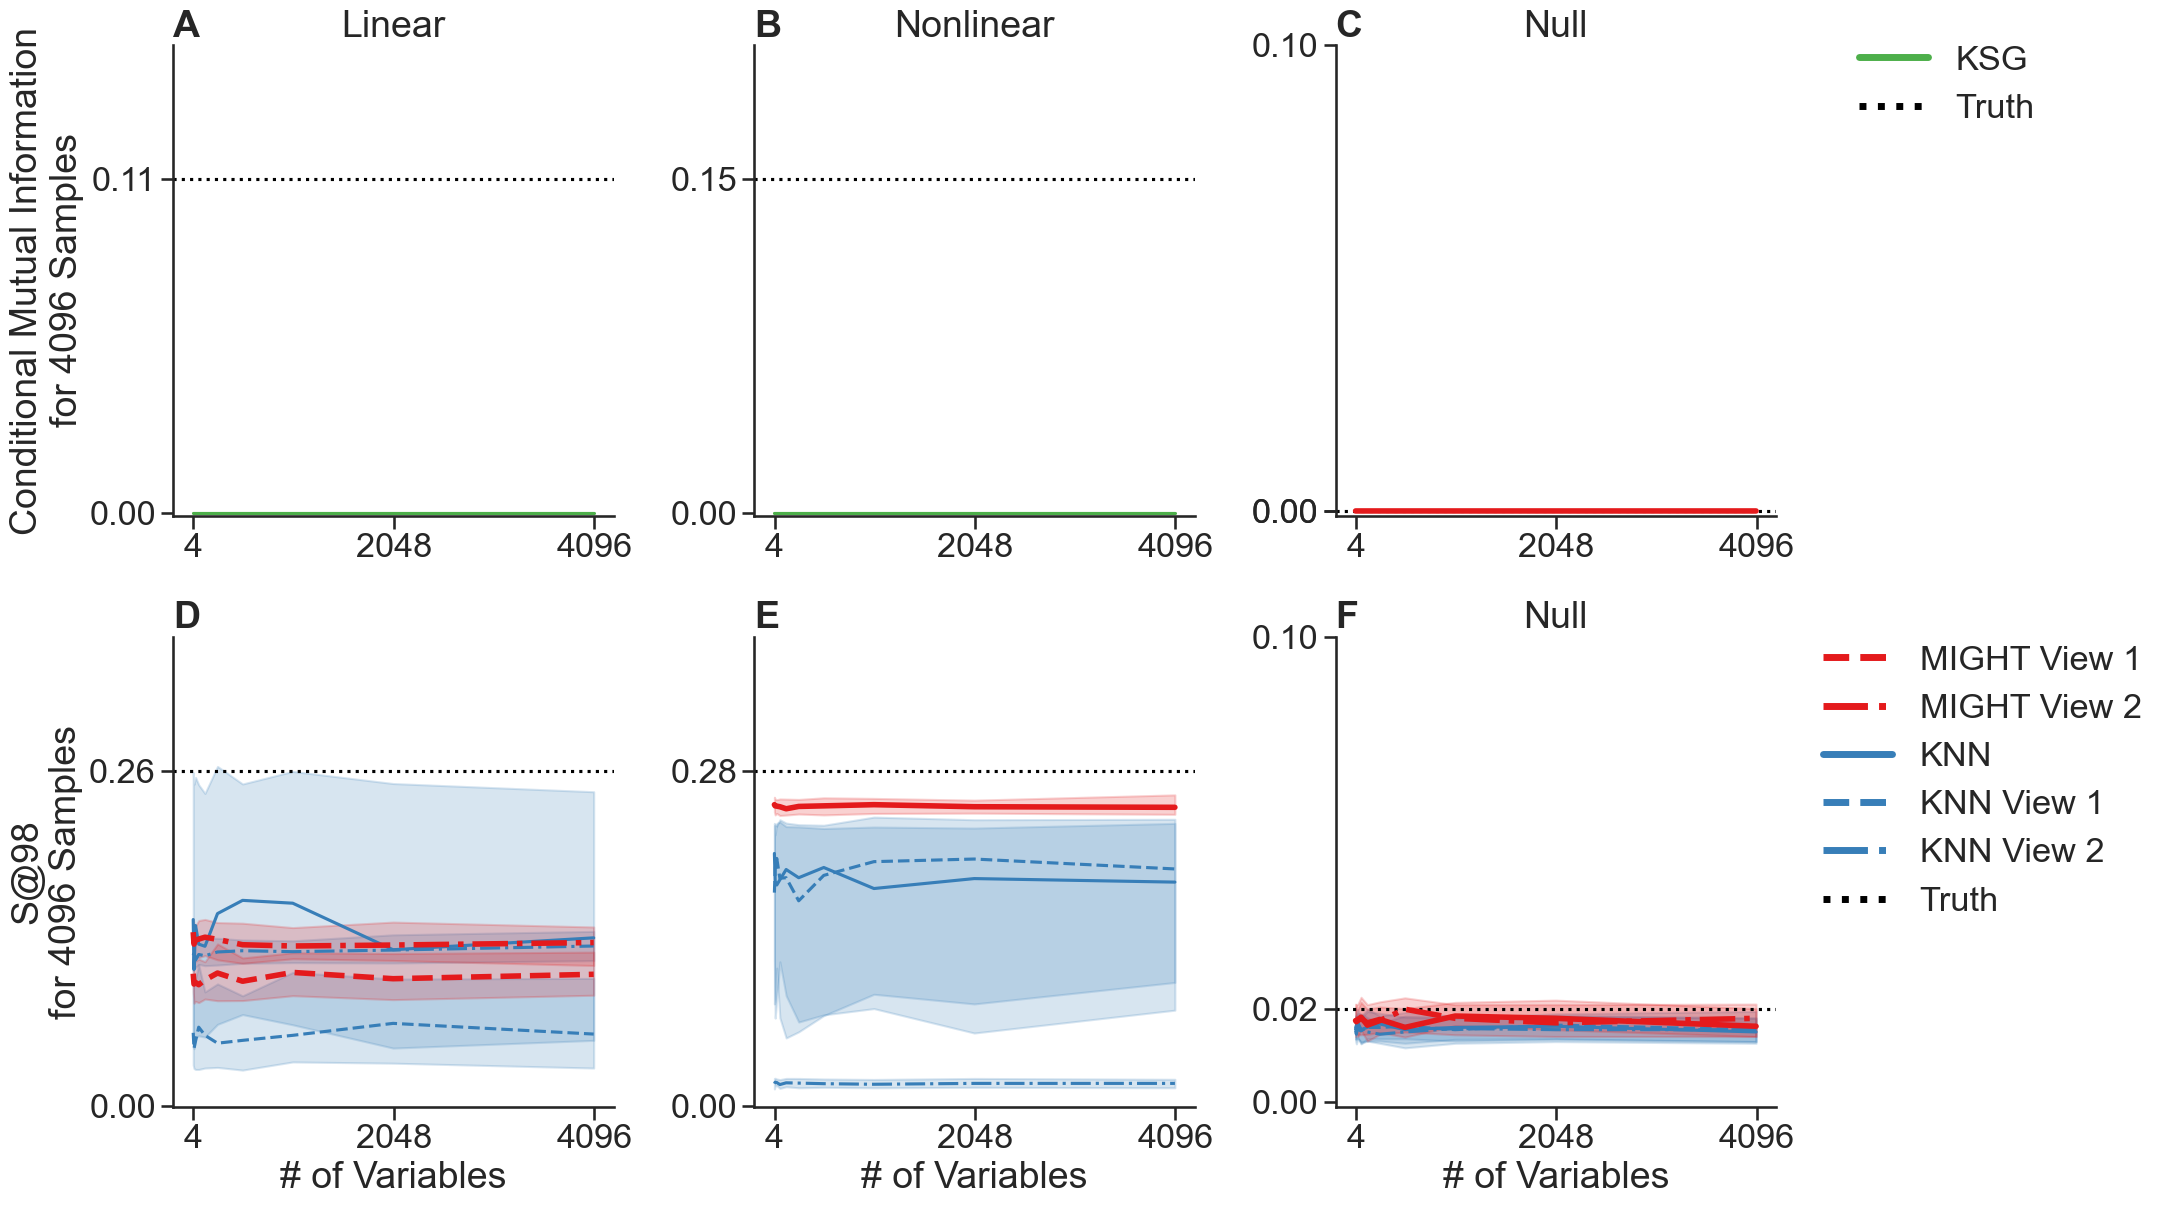

In [85]:
plot_co_stats(plot_type="vs-d", fig_name="figure-6")

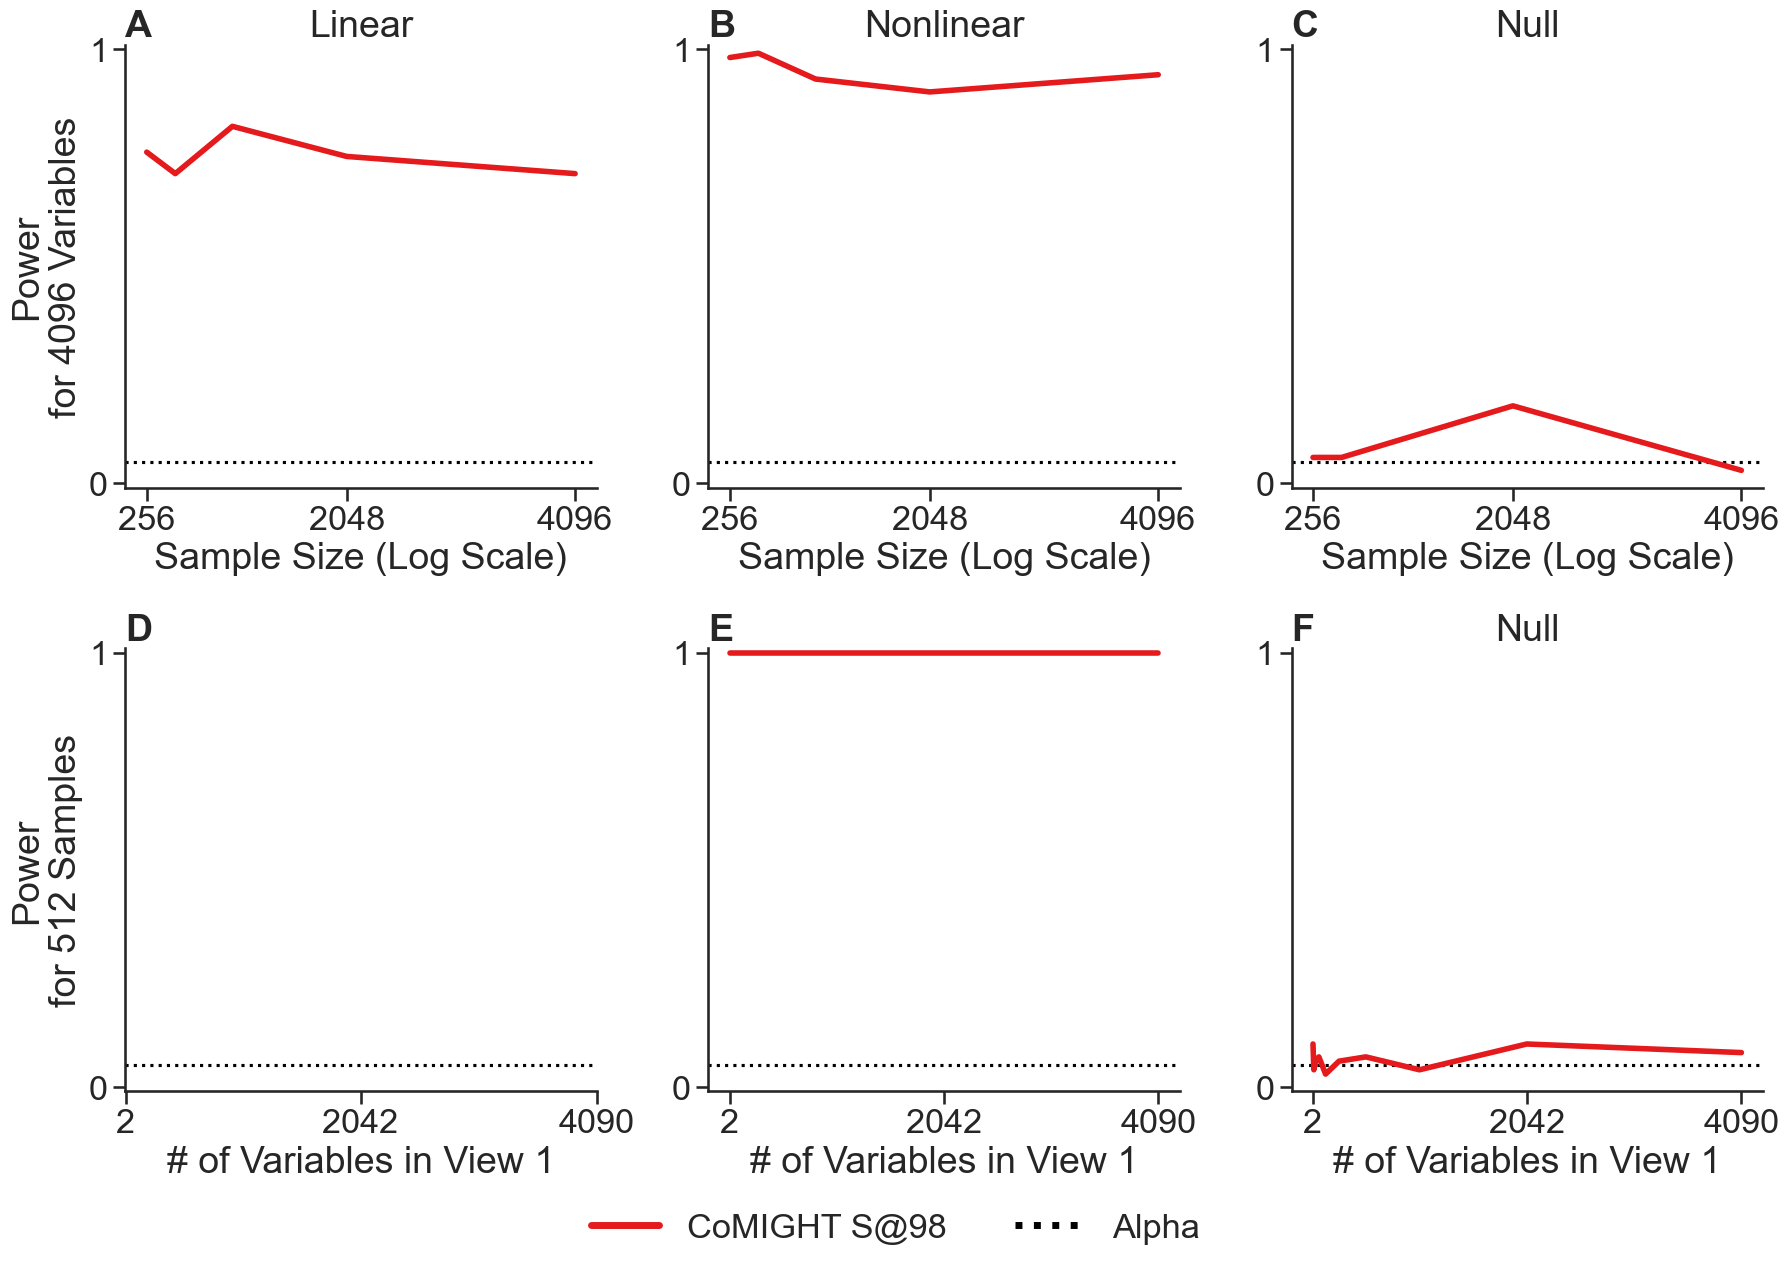

In [86]:
plot_co_power(fig_name="figure-s6")